# Motion Estimation using Optical Flow
Recent advancements in computer vision have enabled machines to interpret their surroundings using techniques like object detection, which identifies instances of specific object classes, and semantic segmentation, which classifies each pixel in an image.

Despite these advancements, most real-time video processing implementations focus solely on analyzing spatial relationships within individual frames (x, y), ignoring temporal information (t). In other words, they treat each frame as an independent image and analyze them separately without considering connections between consecutive frames. But what if we need to understand the relationships between frames? For instance, tracking vehicle motion across frames to calculate its velocity and predict its future position requires incorporating temporal context.

Or, alternatively, what if we require information on human pose relationships between consecutive frames to recognize human actions such as archery, baseball, and basketball?

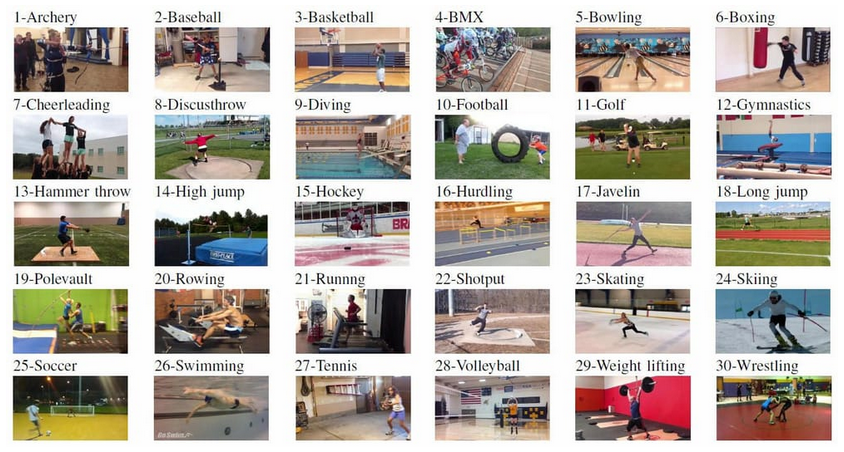

In this experiment, we will learn what Optical Flow is, how to implement its two main variants (sparse and dense), and also get a big picture of more recent approaches involving deep learning and promising future directions.

## 1. What is Optical Flow?
Let us begin with a high-level understanding of optical flow. Optical flow is the motion of objects between consecutive frames of sequence, caused by the relative movement between the object or camera. The problem of optical flow may be expressed as:

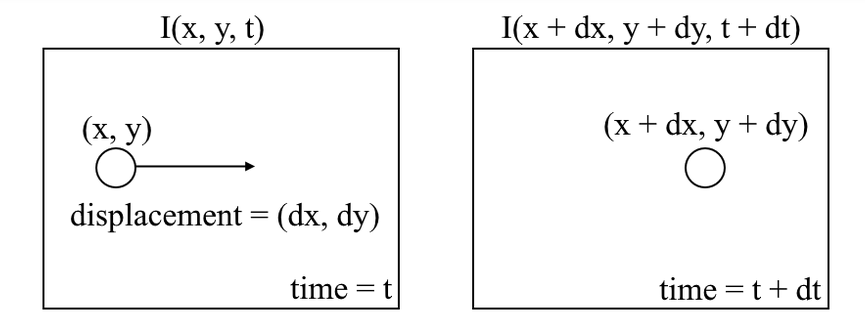

where between consecutive frames, we can express the image intensity $(I)$ as a function of space $(x,y)$ and time $(t)$. In other words, if we take the first image $I(x,y,t)$ and move its pixels by $(dx,dy)$ over $t$ time, we obtain the new image $I(x+dx,y+dy,t+dt)$.

First, we assume that pixel intensities of an object are constant between consecutive frames and then Neighbouring pixels have similar motion.

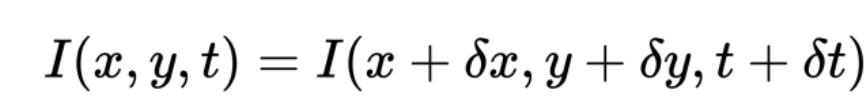

Second, we take the Taylor Series Approximation of the RHS and remove common terms.
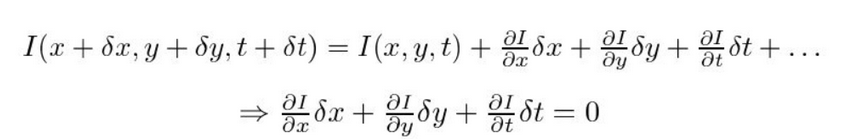

Third, we divide by $dt$ to derive the optical flow equation:
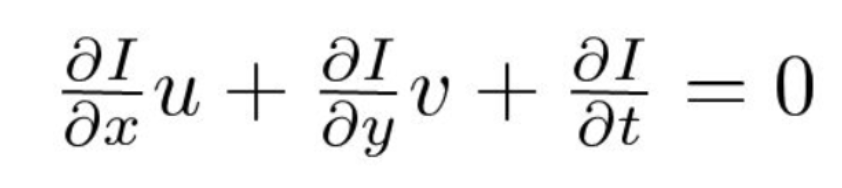

where $u=dx/dt$ and $v=dy/dt$

$dI/dx$, $dI/dy$, and $dI/dt$ are the image gradients along the horizontal axis, the vertical axis, and time. Hence, we conclude with the problem of optical flow, that is, solving $u(dx/dt)$ and $v(dy/dt)$ to determine movement over time. You may notice that we cannot directly solve the optical flow equation for $u$ and $v$ since there is only one equation for two unknown variables. We will implement some methods such as the Lucas-Kanade method to address this issue.

## Sparse vs Dense Optical Flow
Sparse optical flow gives the flow vectors of some "interesting features" (say few pixels depicting the edges or corners of an object) within the frame while Dense optical flow, which gives the flow vectors of the entire frame (all pixels) - up to one flow vector per pixel. As you would've guessed, Dense optical flow has higher accuracy at the cost of being slow/computationally expensive.

![image.png](https://nanonets.com/blog/content/images/2019/04/sparse-vs-dense.gif)

## Implementing Sparse Optical Flow
Sparse optical flow selects a sparse feature set of pixels (e.g. interesting features such as edges and corners) to track its velocity vectors (motion). The extracted features are passed in the optical flow function from frame to frame to ensure that the same points are being tracked. There are various implementations of sparse optical flow, including the Lucas–Kanade method, the Horn–Schunck method, the Buxton–Buxton method, and more. We will be using the Lucas-Kanade method with OpenCV, an open source library of computer vision algorithms, for implementation.

### Lucas-Kanade method
We have seen an assumption before, that all the neighbouring pixels will have similar motion. Lucas-Kanade method takes a 3x3 pablem becomes solving 9 equations with two unknown variables which is over-determined. A better solution is obtained with least square fit tch around the point. So all the 9 points have the same motion. We can find $dI/dx$, $dI/dy$, and $dI/dt$ for these 9 points.

So from the user point of view, the idea is simple, we give some points to track, we receive the optical flow vectors of those points. But again there are some problems. Until now, we were dealing with small motions, so it fails when there is a large motion. To deal with this we use pyramids. When we go up in the pyramid, small motions are removed and large motions become small motions. So by applying Lucas-Kanade there, we get optical flow along with the scale.



### 1. Setting up your environment

In [1]:
!pip install opencv-python

### 2. Shi-Tomasi Corner Detector - selecting the pixels to track
For the implementation of sparse optical flow, we only track the motion of a feature set of pixels. Features in images are points of interest which present rich image content information. For example, such features may be points in the image that are invariant to translation, scale, rotation, and intensity changes such as corners.

The Shi-Tomasi Corner Detector is very similar to the popular Harris Corner Detector which can be implemented by the following three procedures:

1. Determine windows (small image patches) with large gradients (variations in image intensity) when translated in both x and y directions.
2. For each window, compute a score R
3. Depending on the value of R, each window is classified as a flat, edge, or corner.

If you would like to know more on a step-by-step mathematical explanation of the Harris Corner Detector, feel free to go through [these slides](https://courses.cs.washington.edu/courses/cse576/06sp/notes/HarrisDetector.pdf).

Shi and Tomasi later made a small but effective modification to the Harris Corner Detector in their paper [Good Features to Track](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=323794).

The modification is to the equation in which score R is calculated. In the Harris Corner Detector, the scoring function is given by:
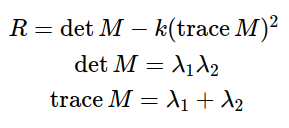
Instead, Shi-Tomasi proposed the scoring function as:
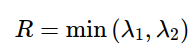

which basically means if R is greater than a threshold, it is classified as a corner. The following compares the scoring functions of Harris (left) and Shi-Tomasi (right) in λ1−λ2 space.

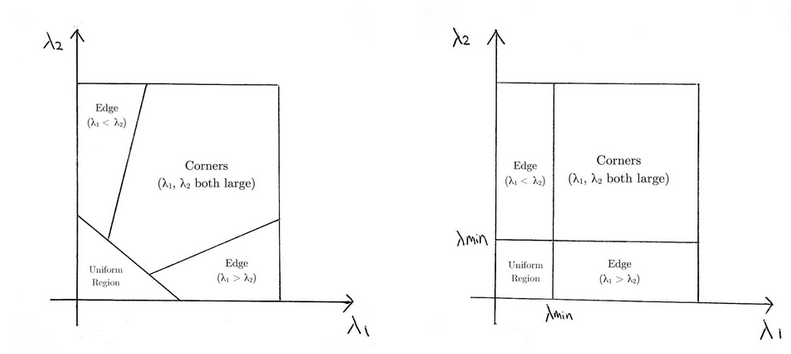

For Shi-Tomasi, only when λ1 and λ2 are above a minimum threshold λmin is the window classified as a corner.
The documentation of OpenCV’s implementation of Shi-Tomasi via `goodFeaturesToTrack()` may be found here.



### 3. Lucas-Kanade: Sparse Optical Flow
Lucas and Kanade proposed an effective technique to estimate the motion of interesting features by comparing two consecutive frames in their paper An Iterative Image Registration Technique with an Application to Stereo Vision. The Lucas-Kanade method works under the following assumptions:

1. Two consecutive frames are separated by a small time increment $(dt)$ such that objects are not displaced significantly (in other words, the method work best with slow-moving objects).
2. A frame portrays a “natural” scene with textured objects exhibiting shades of gray that change smoothly.

First, under these assumptions, we can take a small 3x3 window (neighborhood) around the features detected by Shi-Tomasi and assume that all nine points have the same motion.

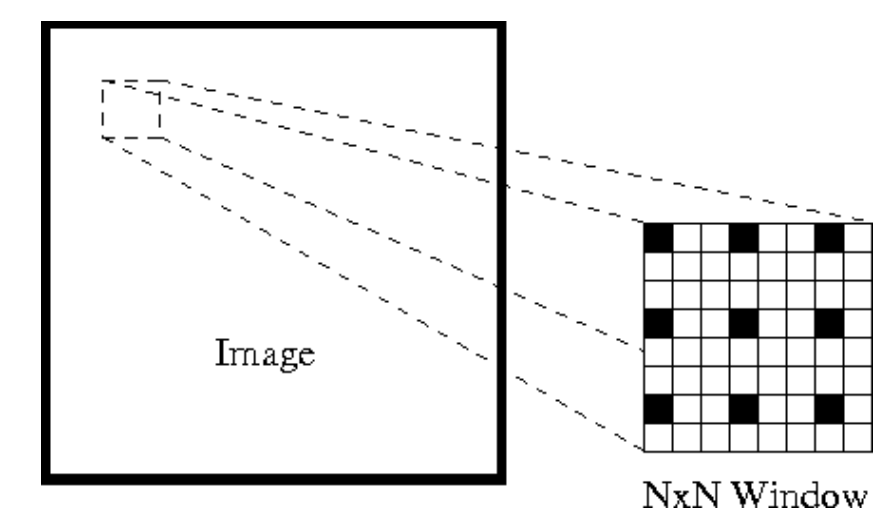

This may be represented as  

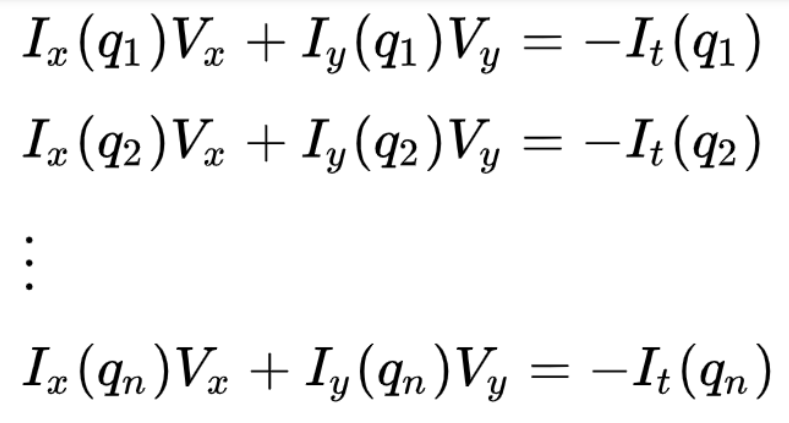  

where $q_1$, $q_2$, …, $q_n$ denote the pixels inside the window (e.g. n = 9 for a 3x3 window) and $I_x(q_i)$, $I_y(q_i)$, and $I_t(q_i)$ denote the partial derivatives of image $I$ with respect to position $(x,y)$ and time $t$, for pixel $q_i$ at the current time.

This is just the Optical Flow Equation (that we described earlier) for each of the n pixels.

The set of equations may be represented in the following matrix form where $Av=b$:

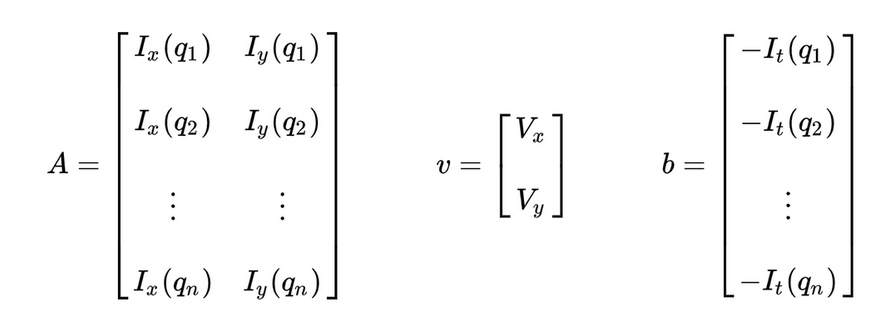  

Take note that previously (see "What is optical flow?" section), we faced the issue of having to solve for two unknown variables with one equation. We now face having to solve for two unknowns ($V_x$ and $V_y$) with nine equations, which is over-determined.

Second, to address the over-determined issue, we apply least squares fitting to obtain the following two-equation-two-unknown problem:  

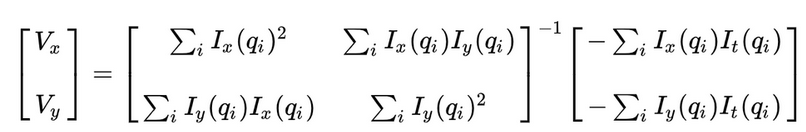  

where $V_x=u=dx/dt$ denotes the movement of $x$ over time and $V_y=v=dy/dt$ denotes the movement of $y$ over time. Solving for the two variables completes the optical flow problem.

In a nutshell, we identify some interesting features to track and iteratively compute the optical flow vectors of these points. However, adopting the Lucas-Kanade method only works for small movements (from our initial assumption) and fails when there is large motion. Therefore, the OpenCV implementation of the Lucas-Kanade method adopts pyramids. 

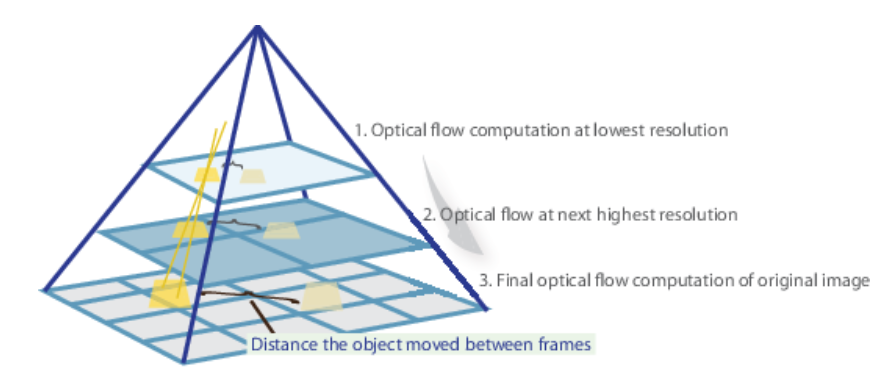

In a high-level view, small motions are neglected as we go up the pyramid and large motions are reduced to small motions - we compute optical flow along with scale. A comprehensive mathematical explanation of OpenCV’s implementation may be found in Bouguet’s notes and the documentation of OpenCV’s implementation of the Lucas-Kanade method via `calcOpticalFlowPyrLK()`


In [2]:
import cv2 as cv
import numpy as np

In [3]:
# Parameters for Shi-Tomasi corner detection
feature_params = dict(maxCorners=300, qualityLevel=0.2, minDistance=2, blockSize=7)

# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

# The video feed is read in as a VideoCapture object
cap = cv.VideoCapture("./videos/cars.mp4")

# Retrieve fps and frame size from input video
fps = cap.get(cv.CAP_PROP_FPS)
frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

# Video writer to save output
out_filename = "./videos/output_sparse_optical_flow.mp4"
fourcc = cv.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
output_writer = cv.VideoWriter(out_filename, fourcc, fps, (frame_width, frame_height))

# Variable for color to draw optical flow tracks
color = (0, 255, 255)

# Read the first frame from the video
ret, first_frame = cap.read()
if not ret:
    print("Error: Unable to read the video file.")
    cap.release()
    output_writer.release()
    cv.destroyAllWindows()
    exit()

# Convert the first frame to grayscale
prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)

# Find the strongest corners in the first frame
prev = cv.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)

# Create an image filled with zero intensities with the same dimensions as the frame - for drawing purposes
mask = np.zeros_like(first_frame)

while cap.isOpened():
    # Read the current frame
    ret, frame = cap.read()
    if not ret:
        break  # Exit loop if no more frames are available

    # Convert the current frame to grayscale
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # Calculate sparse optical flow using Lucas-Kanade method
    prev = cv.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
    next, status, error = cv.calcOpticalFlowPyrLK(prev_gray, gray, prev, None, **lk_params)

    # Select good feature points
    good_old = prev[status == 1].astype(int)
    good_new = next[status == 1].astype(int)

    # Draw optical flow tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv.line(mask, (a, b), (c, d), color, 2)
        frame = cv.circle(frame, (a, b), 3, color, -1)

    # Combine with the original frame
    output = cv.add(frame, mask)

    # Update the previous frame and points
    prev_gray = gray.copy()
    prev = good_new.reshape(-1, 1, 2)

    # Write the output frame to the video file
    output_writer.write(output)

    # Display the output
    cv.imshow("Sparse Optical Flow", output)

    # Break the loop if 'q' is pressed
    if cv.waitKey(10) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
output_writer.release()
cv.destroyAllWindows()

QObject::moveToThread: Current thread (0x2c97ca0) is not the object's thread (0x5cb7660).
Cannot move to target thread (0x2c97ca0)

QObject::moveToThread: Current thread (0x2c97ca0) is not the object's thread (0x5cb7660).
Cannot move to target thread (0x2c97ca0)

QObject::moveToThread: Current thread (0x2c97ca0) is not the object's thread (0x5cb7660).
Cannot move to target thread (0x2c97ca0)

QObject::moveToThread: Current thread (0x2c97ca0) is not the object's thread (0x5cb7660).
Cannot move to target thread (0x2c97ca0)

QObject::moveToThread: Current thread (0x2c97ca0) is not the object's thread (0x5cb7660).
Cannot move to target thread (0x2c97ca0)

QObject::moveToThread: Current thread (0x2c97ca0) is not the object's thread (0x5cb7660).
Cannot move to target thread (0x2c97ca0)

QObject::moveToThread: Current thread (0x2c97ca0) is not the object's thread (0x5cb7660).
Cannot move to target thread (0x2c97ca0)

QObject::moveToThread: Current thread (0x2c97ca0) is not the object's thread

## Implementing Dense Optical Flow
We’ve previously computed the optical flow for a sparse feature set of pixels. Dense optical flow attempts to compute the optical flow vector for every pixel of each frame. While such computation may be slower, it gives a more accurate result and a denser result suitable for applications such as learning structure from motion and video segmentation. There are various implementations of dense optical flow. We will be using the Farneback method, one of the most popular implementations, with using OpenCV, an open source library of computer vision algorithms, for implementation.

### Farneback Optical Flow
Gunnar Farneback proposed an effective technique to estimate the motion of interesting features by comparing two consecutive frames in his paper [Two-Frame Motion Estimation Based on Polynomial Expansion](http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf).

First, the method approximates the windows (see Lucas Kanade section of sparse optical flow implementation for more details) of image frames by quadratic polynomials through polynomial expansion transform. Second, by observing how the polynomial transforms under translation (motion), a method to estimate displacement fields from polynomial expansion coefficients is defined. After a series of refinements, dense optical flow is computed. Farneback’s paper is fairly concise and straightforward to follow so I highly recommend going through the paper if you would like a greater understanding of its mathematical derivation.

### Implementation

In [ ]:
# The video feed is read in as a VideoCapture object
cap = cv.VideoCapture("./videos/cars.mp4")


# Video writer to save output
out_filename = "./videos/output_dense_optical_flow.mp4"
fourcc = cv.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
output_writer = cv.VideoWriter(out_filename, fourcc, fps, (frame_width, frame_height))


# ret = a boolean return value from getting the frame, first_frame = the first frame in the entire video sequence
ret, first_frame = cap.read()

if not ret:
    print("Error: Unable to read the video file.")
    cap.release()
    output_writer.release()
    cv.destroyAllWindows()
    exit()

# Converts frame to grayscale because we only need the luminance channel for detecting edges - less computationally expensive
prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)

# Creates an image filled with zero intensities with the same dimensions as the frame
mask = np.zeros_like(first_frame)

# Sets image saturation to maximum
mask[..., 1] = 255

while(cap.isOpened()):
    # ret = a boolean return value from getting the frame, frame = the current frame being projected in the video
    ret, frame = cap.read()
    
    # Opens a new window and displays the input frame
    cv.imshow("input", frame)
    
    # Converts each frame to grayscale - we previously only converted the first frame to grayscale
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    # Calculates dense optical flow by Farneback method
    # https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#calcopticalflowfarneback
    flow = cv.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    
    # Computes the magnitude and angle of the 2D vectors
    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])
    
    # Sets image hue according to the optical flow direction
    mask[..., 0] = angle * 180 / np.pi / 2
    
    # Sets image value according to the optical flow magnitude (normalized)
    mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
    
    # Converts HSV to RGB (BGR) color representation
    rgb = cv.cvtColor(mask, cv.COLOR_HSV2BGR)
    
    # Write the output frame to the video file
    output_writer.write(output)

    
    # Opens a new window and displays the output frame
    cv.imshow("dense optical flow", rgb)
    
    # Updates previous frame
    prev_gray = gray
    # Frames are read by intervals of 1 millisecond. The programs breaks out of the while loop when the user presses the 'q' key
    if cv.waitKey(1) & 0xFF == ord('q'):
        break
# The following frees up resources and closes all windows
cap.release()
output_writer.release()
cv.destroyAllWindows()

QObject::moveToThread: Current thread (0x2c97ca0) is not the object's thread (0x5cb7660).
Cannot move to target thread (0x2c97ca0)

QObject::moveToThread: Current thread (0x2c97ca0) is not the object's thread (0x5cb7660).
Cannot move to target thread (0x2c97ca0)

QObject::moveToThread: Current thread (0x2c97ca0) is not the object's thread (0x5cb7660).
Cannot move to target thread (0x2c97ca0)

QObject::moveToThread: Current thread (0x2c97ca0) is not the object's thread (0x5cb7660).
Cannot move to target thread (0x2c97ca0)

QObject::moveToThread: Current thread (0x2c97ca0) is not the object's thread (0x5cb7660).
Cannot move to target thread (0x2c97ca0)

QObject::moveToThread: Current thread (0x2c97ca0) is not the object's thread (0x5cb7660).
Cannot move to target thread (0x2c97ca0)

QObject::moveToThread: Current thread (0x2c97ca0) is not the object's thread (0x5cb7660).
Cannot move to target thread (0x2c97ca0)

QObject::moveToThread: Current thread (0x2c97ca0) is not the object's thread

error: OpenCV(4.10.0) /io/opencv/modules/highgui/src/window.cpp:973: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'imshow'


: 